<h1><center><font size="6">Prueba Técnica DATTA</font></center></h1>

# <a id='0'>Contenido</a>

- <a href='#1'>1. Introducción</a>  
- <a href='#2'>2. Cargar base de datos</a>   
- <a href='#3'>3. Limpieza de datos</a>
- <a href='#4'>4. Análisis Exploratorio de Datos</a>
- <a href='#5'>5. Ingeniería de Características</a>
- <a href='#6'>6. Creación de modelos de predicción de riesgo</a>
- <a href='#7'>7. Evaluacion y predicción</a>
- <a href='#8'>8. Simulación del nivel de riesgo</a>
- <a href='#9'>9. Conclusiones</a>

# <a id="1">1. Introducción</a>

Creación de un modelo de riesgo crediticio donde se puede simular el nivel de riesgo que representa el préstamo de cierta cantidad de dinero para una persona natural.   

# <a id="2">2. Cargar base de datos</a>

En esta sección se cargará la base de datos utilizada para la creación del modelo de riesgo y la simulación. La base de datos utilizada se encuentra en el siguiente [link](https://www.kaggle.com/uciml/german-credit).

In [1]:
import pandas as pd # procesamiento de datos, CSV file I/O (ejemplo. pd.read_csv)
import numpy as np # manejar matrices
import matplotlib as mlp  # graficar data
import matplotlib.pyplot as plt  # graficar data
import seaborn as sns # graficar data

In [2]:
import os
import sys

In [3]:
df = pd.read_csv(os.getcwd() + '\german_credit_data.csv',index_col=0)
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


Se renombran las columnas para faciliar su entendimiento.

In [4]:
df.columns = ['Edad','Genero','Trabajo','Alojamiento','CuentasAhorro','CuentasCheques','CantidadSolicitada','Duracion','Proposito','Riesgo']
df.sample(5)

,Edad,Genero,Trabajo,Alojamiento,CuentasAhorro,CuentasCheques,CantidadSolicitada,Duracion,Proposito,Riesgo
226,27,male,2,own,rich,moderate,10961,48,radio/TV,bad
22,48,male,1,rent,little,little,2241,10,car,good
328,31,male,2,own,little,rich,4473,36,radio/TV,good
650,50,male,3,free,little,little,7476,48,education,good
905,20,male,3,rent,little,little,1107,12,radio/TV,good


1. Edad (variable numérica)
1. Genero (texto: hombre, mujer)
1. Trabajo (variable numérica: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
1. Alojamiento (texto: own, rent, or free)
1. Cuentas de Ahorro (texto: little, moderate, quite rich, rich)
1. Cuentas de Cheque (texto: little, moderate, rich)
1. Cantidad Prestada o Solicitada (variable numérica)
1. Duration (variable numérica, en meses)
1. Propósito del prestamo (texto: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others
1. Riesgo (Variable objetivo - Bajo o Alto)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Edad                1000 non-null   int64 
 1   Genero              1000 non-null   object
 2   Trabajo             1000 non-null   int64 
 3   Alojamiento         1000 non-null   object
 4   CuentasAhorro       817 non-null    object
 5   CuentasCheques      606 non-null    object
 6   CantidadSolicitada  1000 non-null   int64 
 7   Duracion            1000 non-null   int64 
 8   Proposito           1000 non-null   object
 9   Riesgo              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


<a href="#0"><font size="1">Volver al inicio</font></a>

# <a id="3">3. Limpieza de Datos</a>

A continuación, Se revisa la cantidad de valores faltantes en la matriz.

In [6]:
df.isnull().sum()

Edad                    0
Genero                  0
Trabajo                 0
Alojamiento             0
CuentasAhorro         183
CuentasCheques        394
CantidadSolicitada      0
Duracion                0
Proposito               0
Riesgo                  0
dtype: int64

Ya que cuentas de ahorro y de cheques tienen valores nulos, se trabaja bajo la hipótesis de que la variable de poco/little se da a partir de más de una cuenta de dicho tipo. Por lo que los valores nulos representan registros que no disponen de cuentas en la entidad prestamista. Se llenaran con el texto None/Ninguna cuenta.

In [7]:
df.fillna('none',inplace=True)
dfc = df[(df.CuentasCheques == 'none') & (df.CuentasAhorro == 'none')]
dfc.shape[0]

99

99 registros no cuentan con ningún tipo de cuenta.

In [8]:
df.loc[df.Riesgo == 'good', 'Riesgo'] = 'Bajo'
df.loc[df.Riesgo == 'bad', 'Riesgo'] = 'Alto'
df.Riesgo.value_counts()

Bajo    700
Alto    300
Name: Riesgo, dtype: int64

# <a href="#0"><font size="1">Volver al inicio</font></a>

# <a id="4">4. Análisis Exploratorio de Datos</a>

A continuación, se revisan las columnas cuyos datos son varibles tipo texto o categóricas.

In [9]:
cat_cols = [col for col in df.columns if df[col].dtypes == 'O']

for col in cat_cols:
    print(df[col].value_counts(), "\n")

male      690
female    310
Name: Genero, dtype: int64 

own     713
rent    179
free    108
Name: Alojamiento, dtype: int64 

little        603
none          183
moderate      103
quite rich     63
rich           48
Name: CuentasAhorro, dtype: int64 

none        394
little      274
moderate    269
rich         63
Name: CuentasCheques, dtype: int64 

car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
repairs                 22
domestic appliances     12
vacation/others         12
Name: Proposito, dtype: int64 

Bajo    700
Alto    300
Name: Riesgo, dtype: int64 



<AxesSubplot:>

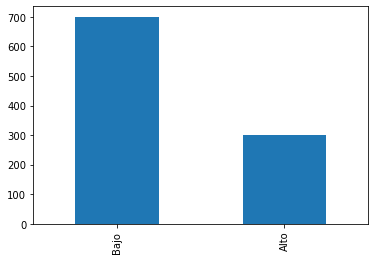

In [10]:
df.Riesgo.value_counts().plot(kind='bar')

Alrededor de un 70% de las personas que realizó un préstamo realizó cumplidamente sus pagos. Es decir, que la mayoría de registros corresponden a buenos prestatarios o de bajo riesgo. 

<AxesSubplot:>

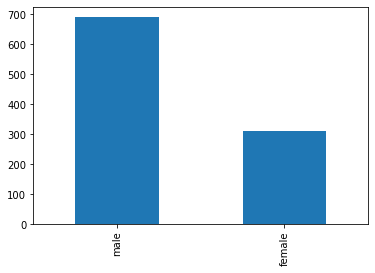

In [11]:
df.Genero.value_counts().plot(kind='bar')

La mayoría de los registros son de hombres, siendo una relación cercana de 2:1 frente a las mujeres.

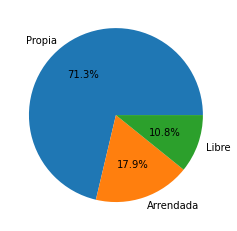

In [12]:
plt.pie(df.Alojamiento.value_counts(),labels=['Propia','Arrendada','Libre'],autopct='%0.1f%%')
plt.show()

Alrededor de un 70% de las personas que realizó un préstamo tienen casa propia.

<AxesSubplot:xlabel='Alojamiento'>

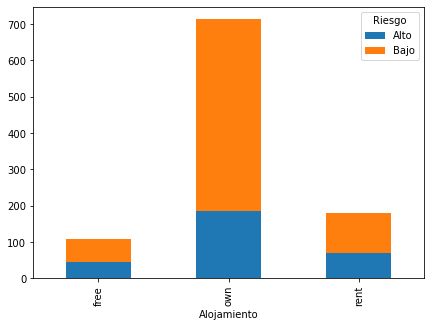

In [13]:
df.groupby(["Alojamiento", "Riesgo"]).size().unstack().plot(kind='bar', stacked=True, figsize=(7,5)) 

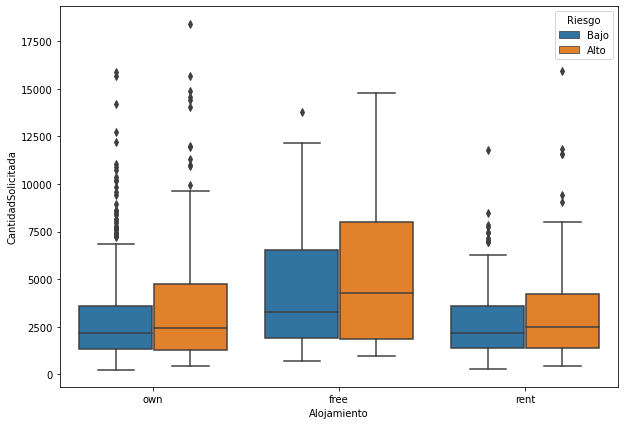

In [14]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
ax = sns.boxplot(x='Alojamiento', y='CantidadSolicitada', data=df, hue="Riesgo")
plt.show()

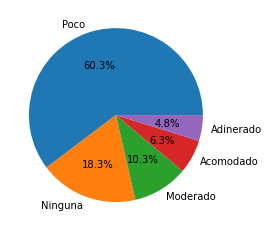

In [15]:
plt.pie(df.CuentasAhorro.value_counts(),labels=['Poco','Ninguna','Moderado','Acomodado','Adinerado'],autopct='%0.1f%%')
plt.show()

<AxesSubplot:xlabel='CuentasAhorro'>

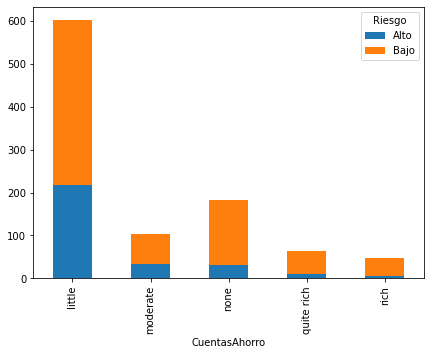

In [16]:
df.groupby(["CuentasAhorro", "Riesgo"]).size().unstack().plot(kind='bar', stacked=True, figsize=(7,5)) 

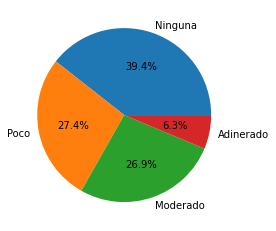

In [17]:
plt.pie(df.CuentasCheques.value_counts(),labels=['Ninguna','Poco','Moderado','Adinerado'],autopct='%0.1f%%')
plt.show()

<AxesSubplot:xlabel='CuentasCheques'>

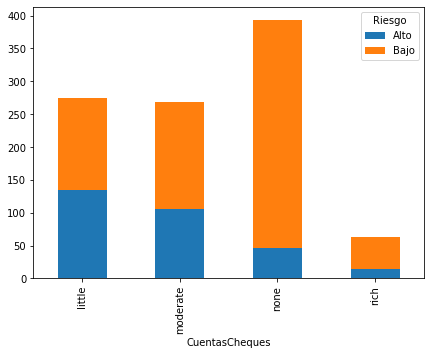

In [18]:
df.groupby(["CuentasCheques", "Riesgo"]).size().unstack().plot(kind='bar', stacked=True, figsize=(7,5)) 

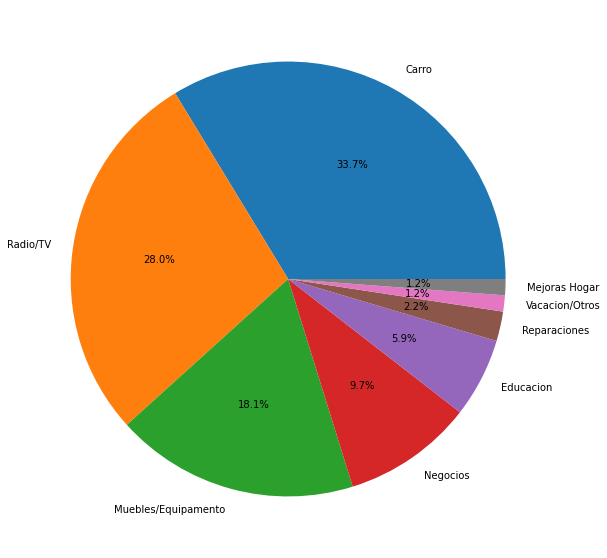

In [19]:
plt.figure(figsize=(15,10))
plt.pie(df.Proposito.value_counts(),labels=['Carro','Radio/TV','Muebles/Equipamento','Negocios','Educacion','Reparaciones','Vacacion/Otros','Mejoras Hogar'],autopct='%0.1f%%')
plt.show()

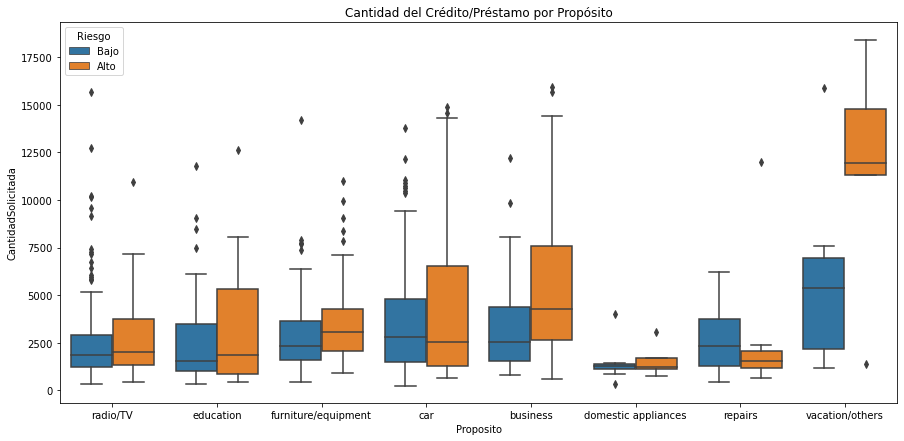

In [20]:
fig, ax = plt.subplots(1,1,figsize=(15,7))
ax = sns.boxplot(x='Proposito', y='CantidadSolicitada', data=df, hue="Riesgo")
ax.set_title('Cantidad del Crédito/Préstamo por Propósito')
plt.show()

Alrededor del 80% de los propósitos de los prestamos corresponda a una de las siguientes categorías: carro, radio/TV o muebles/equipos.

Adicionalmente es clara que la cantidad de datos perteneciente a un registro de riesgo bajo o alto varía en cada características en gran manera. Pero siendo siempre mayor la cantidad solicitada.

A continuación, se revisan las columnas cuyos datos son varibles tipo numérico.

In [21]:
df.describe()

,Edad,Trabajo,CantidadSolicitada,Duracion
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


4 Varibles numéricas.

El promedio de edad a la hora de hacer un prestamo es de 35 años, son trabajadores hábiles, la mitad de los prestámos está entre 1365 - 2319 EUR y duran en promedio 21 meses.   

Cantidad de variables numéricas:  4


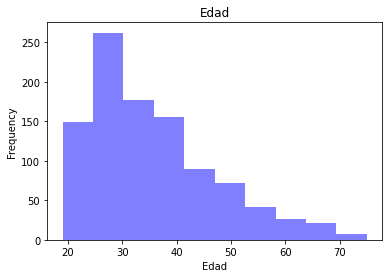

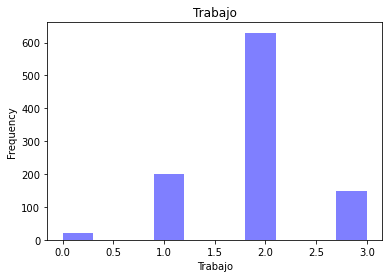

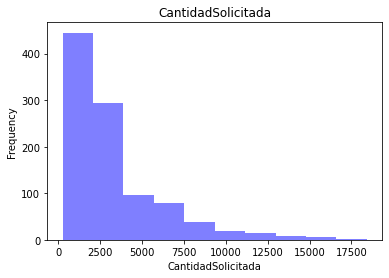

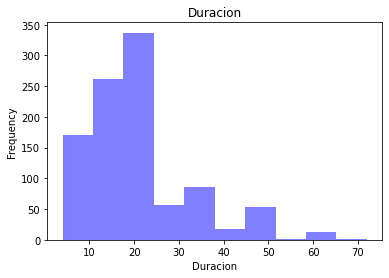

4 variables han sido gráficadas


In [22]:
num_cols = [col for col in df.columns if df[col].dtypes != 'O' and col not in "Id"]
print('Cantidad de variables numéricas: ', len(num_cols))

def hist_for_nums(data, numeric_cols):
    col_counter = 0
    data = data.copy()
    for col in numeric_cols:
        data[col].plot.hist(alpha=0.5, color='b')
        plt.xlabel(col)
        plt.title(col)
        plt.show()
        col_counter += 1
    print(col_counter, "variables han sido gráficadas")


hist_for_nums(df, num_cols)

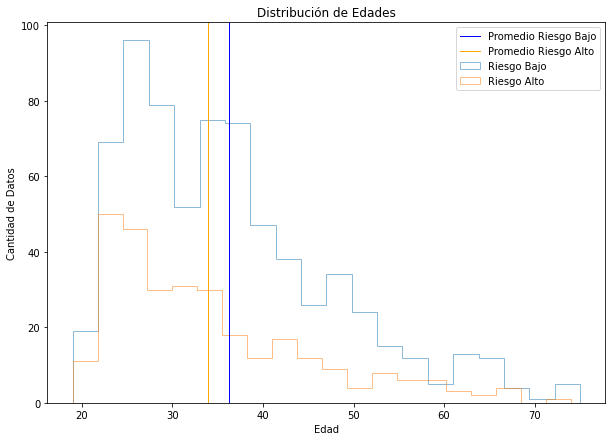

In [23]:
dfB = df[df.Riesgo=='Bajo']
dfM = df[df.Riesgo=='Alto']

fig, ax = plt.subplots(1,1,figsize=(10,7))
ax.hist(dfB.Edad, bins=20,alpha=0.5,histtype='step',label='Riesgo Bajo')
ax.hist(dfM.Edad, bins=20,alpha=0.5,histtype='step',label='Riesgo Alto')
ax.axvline(dfB.Edad.mean(),color='b',linestyle='solid',linewidth=1,label='Promedio Riesgo Bajo')
ax.axvline(dfM.Edad.mean(),color='orange',linestyle='solid',linewidth=1,label='Promedio Riesgo Alto')
ax.set_title('Distribución de Edades')
plt.xlabel("Edad")
plt.ylabel("Cantidad de Datos")
legend = ax.legend(loc='upper right', shadow=False, fontsize='medium')
plt.show()

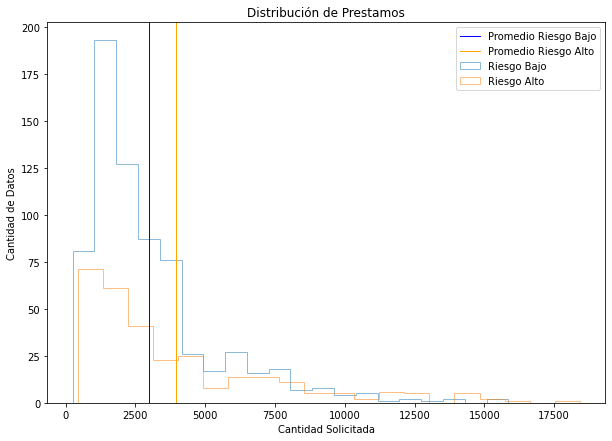

In [24]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
ax.hist(dfB.CantidadSolicitada, bins=20,alpha=0.5,histtype='step',label='Riesgo Bajo')
ax.hist(dfM.CantidadSolicitada, bins=20,alpha=0.5,histtype='step',label='Riesgo Alto')
ax.axvline(dfB.CantidadSolicitada.mean(),color='b',linestyle='solid',linewidth=1,label='Promedio Riesgo Bajo')
ax.axvline(dfM.CantidadSolicitada.mean(),color='orange',linestyle='solid',linewidth=1,label='Promedio Riesgo Alto')
ax.set_title('Distribución de Prestamos')
plt.xlabel("Cantidad Solicitada")
plt.ylabel("Cantidad de Datos")
legend = ax.legend(loc='upper right', shadow=False, fontsize='medium')
plt.show()

Las distribuciones de edades y cantidad solicitadas son distribuciones con sesgo a la derecha unimodales (un único pico o montaña). Dónde la mediana está ubicada a la izquierda de la media. 
Ahora se crearan intervalos de edades para entender mejor los datos. 18-25: Estudiante, 26-35:Joven, 35-60: Adulto y 60++ mayor

In [25]:
intervalo = (18, 25, 35, 60, 100)

cats = ['Estudiante', 'Joven', 'Adulto', 'Mayor']
df["GEdad"] = pd.cut(df.Edad, intervalo, labels=cats)

In [26]:
df.sample(5)

,Edad,Genero,Trabajo,Alojamiento,CuentasAhorro,CuentasCheques,CantidadSolicitada,Duracion,Proposito,Riesgo,GEdad
921,37,male,3,own,quite rich,none,12749,48,radio/TV,Bajo,Adulto
850,33,male,2,rent,little,little,2235,20,car,Alto,Joven
126,40,male,1,own,little,little,701,12,radio/TV,Bajo,Adulto
948,43,male,1,own,little,none,1533,18,furniture/equipment,Alto,Adulto
546,37,female,2,own,little,none,2022,24,car,Bajo,Adulto


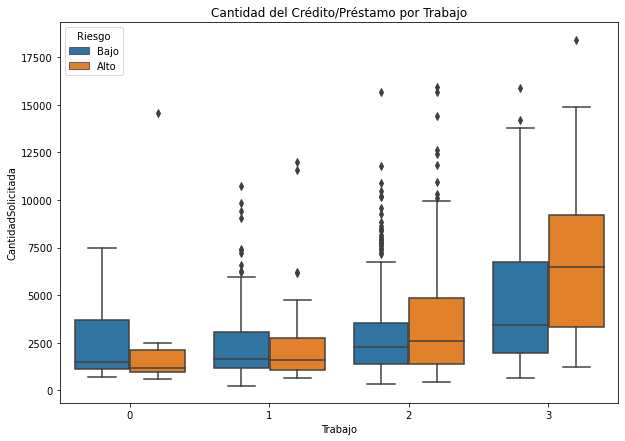

In [27]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
ax = sns.boxplot(x='Trabajo', y='CantidadSolicitada', data=df, hue="Riesgo")
ax.set_title('Cantidad del Crédito/Préstamo por Trabajo')
plt.show()

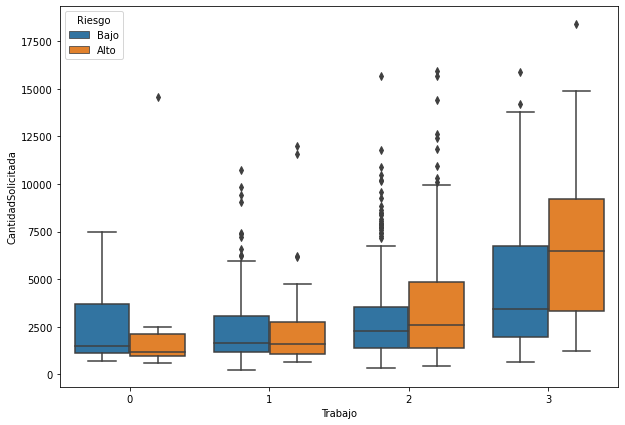

In [28]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
ax = sns.boxplot(x='Trabajo', y='CantidadSolicitada', data=df, hue="Riesgo")
plt.show()

In [29]:
dfB.describe()

,Edad,Trabajo,CantidadSolicitada,Duracion
count,700.000000,700.000000,700.000000,700.000000
mean,36.224286,1.890000,2985.457143,19.207143
std,11.381145,0.646914,2401.472278,11.079564
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1375.500000,12.000000
50%,34.000000,2.000000,2244.000000,18.000000
75%,42.250000,2.000000,3634.750000,24.000000
max,75.000000,3.000000,15857.000000,60.000000


In [30]:
dfM.describe()

,Edad,Trabajo,CantidadSolicitada,Duracion
count,300.000000,300.000000,300.000000,300.000000
mean,33.963333,1.936667,3938.126667,24.860000
std,11.222379,0.668940,3535.818955,13.282639
min,19.000000,0.000000,433.000000,6.000000
25%,25.000000,2.000000,1352.500000,12.000000
50%,31.000000,2.000000,2574.500000,24.000000
75%,40.000000,2.000000,5141.500000,36.000000
max,74.000000,3.000000,18424.000000,72.000000


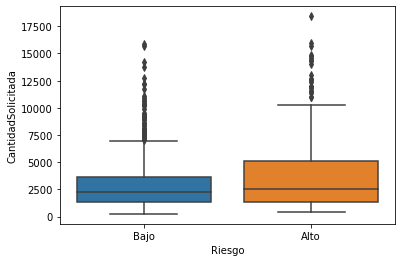

In [31]:
ax = sns.boxplot(x='Riesgo', y='CantidadSolicitada', data=df)

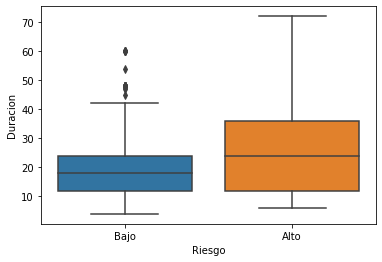

In [32]:
ax = sns.boxplot(x='Riesgo', y='Duracion', data=df)

Al analizar los dataset de los registros de bajo riesgo y alto riesgo, se nota una diferencia en las cantidades solicitadas, en dónde las personas catalogadas como malos prestatarios o de alto riesgo solicitaban valores mayores (se nota claramente en el Cuartile 3/75%, dónde hay 1500 EUR de diferencia en los préstamos). 

De manera similar, la duración de los prestamos era mayor en los prestatarios luego caracterizados como malos o de riesgo alto.

# <a href="#0"><font size="1">Volver al inicio</font></a>

# <a id="5">5. Ingeniería de Características</a>

Iniciamos revisando la cantidad de los datos lejanos al resto del dataset o Outliers.

In [33]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.25)
    quartile3 = dataframe[variable].quantile(0.75)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def has_outliers(dataframe, num_col_names, plot=False):
    variable_names = []
    for col in num_col_names:
        low_limit, up_limit = outlier_thresholds(dataframe, col)
        if dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)].any(axis=None):
            number_of_outliers = dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)].shape[0]
            print(col, ":", number_of_outliers)
            variable_names.append(col)
            if plot:
                sns.boxplot(x=dataframe[col])
                plt.show()
    return variable_names


has_outliers(df, num_cols)

Edad : 23
Trabajo : 370
CantidadSolicitada : 72
Duracion : 70


['Edad', 'Trabajo', 'CantidadSolicitada', 'Duracion']

Ahora, se ajustan los límites de los umbrales para los valores lejanos.

In [34]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


for col in num_cols:
    replace_with_thresholds(df, col)

has_outliers(df, num_cols)

[]

In [35]:
import sklearn # aprendizaje automático / machine learning
from sklearn import preprocessing # manejar data no numerica 
from sklearn.model_selection import StratifiedKFold # validación cruzada
# Tipo de validación cruzada, es una variación de KFold que retorna pliegues. Los pleigues son realizados a preservar el 
# porcentaje de muestras para cada clase.
from sklearn.model_selection import cross_validate # Técnica utilizada para evaluar los resultados de un análisis estadístico
# y garantizar que son independientes de la partición entre datos de entrenamiento y prueba.
# https://es.wikipedia.org/wiki/Validación_cruzada
# Se utiliza en entornos donde el objetivo principal es la predicción y se quiere estimar la precisión de un modelo que se 
# llevará a cabo a la práctica.
from sklearn.model_selection import cross_val_score # Obtener la puntuación del modelo
from sklearn.model_selection import train_test_split # Dividir los datos en datos de entrenamiento y datos de prueba del modelo. 
from sklearn.model_selection import ShuffleSplit # Permutador aleatorio utilizado en validación cruzada
from sklearn.pipeline import make_pipeline # Cosntruye una tipería para los estimadores dados.
from sklearn import metrics # Obtener las métricas de los modelos (precision, score, recall, accuracy)

Codificador discreto de valores enteros.

In [36]:
label_encoder = preprocessing.LabelEncoder()

In [37]:
df.head()

,Edad,Genero,Trabajo,Alojamiento,CuentasAhorro,CuentasCheques,CantidadSolicitada,Duracion,Proposito,Riesgo,GEdad
0,64.5,male,2.0,own,none,little,1169.0,6.0,radio/TV,Bajo,Mayor
1,22.0,female,2.0,own,little,moderate,5951.0,42.0,radio/TV,Alto,Estudiante
2,49.0,male,2.0,own,little,none,2096.0,12.0,education,Bajo,Adulto
3,45.0,male,2.0,free,little,little,7882.0,42.0,furniture/equipment,Bajo,Adulto
4,53.0,male,2.0,free,little,little,4870.0,24.0,car,Alto,Adulto


Se cambian las variables categóricas a enteros, utilizando el label encoder.

In [38]:
cat_cols = [col for col in df.columns if df[col].dtypes == 'O']

for col in cat_cols:
    df[col] = label_encoder.fit_transform(df[col])

df['GEdad'] = label_encoder.fit_transform(df['GEdad'])
df.dtypes

Edad                  float64
Genero                  int32
Trabajo               float64
Alojamiento             int32
CuentasAhorro           int32
CuentasCheques          int32
CantidadSolicitada    float64
Duracion              float64
Proposito               int32
Riesgo                  int32
GEdad                   int32
dtype: object

In [39]:
y = pd.DataFrame(df['Riesgo']).to_numpy().astype(np.int)
y.size

1000

Quitamos las columnas redundantes

In [40]:
df.drop(["Edad","Riesgo"], axis = 1, inplace=True)

In [41]:
df.head(3)

,Genero,Trabajo,Alojamiento,CuentasAhorro,CuentasCheques,CantidadSolicitada,Duracion,Proposito,GEdad
0,1,2.0,1,2,0,1169.0,6.0,5,3
1,0,2.0,1,0,1,5951.0,42.0,5,1
2,1,2.0,1,0,2,2096.0,12.0,3,0


Se construye la matriz de características

In [42]:
X = pd.DataFrame(df).astype(np.float)
X

,Genero,Trabajo,Alojamiento,CuentasAhorro,CuentasCheques,CantidadSolicitada,Duracion,Proposito,GEdad
0,1.0,2.0,1.0,2.0,0.0,1169.0,6.0,5.0,3.0
1,0.0,2.0,1.0,0.0,1.0,5951.0,42.0,5.0,1.0
2,1.0,2.0,1.0,0.0,2.0,2096.0,12.0,3.0,0.0
3,1.0,2.0,0.0,0.0,0.0,7882.0,42.0,4.0,0.0
4,1.0,2.0,0.0,0.0,0.0,4870.0,24.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
995,0.0,2.0,1.0,0.0,2.0,1736.0,12.0,4.0,2.0
996,1.0,2.0,1.0,0.0,0.0,3857.0,30.0,1.0,0.0
997,1.0,2.0,1.0,0.0,2.0,804.0,12.0,5.0,0.0
998,1.0,2.0,0.0,0.0,0.0,1845.0,42.0,5.0,1.0


In [43]:
X.shape

(1000, 9)

9 columnas seran utilizadas para predecir el riesgo del préstamo.

In [44]:
y # 0 y 1s representando el riesgo
# Muestra
y[:10]

array([[1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0]])

In [45]:
y = y.ravel() #.ravel convierte el arreglod de datos a la forma (n, )
y[:10]

array([1, 0, 1, 1, 0, 1, 1, 1, 1, 0])

Se debe estandariza la matriz de características con StandardScaler, ya que normalizar los datos ayuda a no darle mayor peso a una característica sobre otra.

In [46]:
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

# <a href="#0"><font size="1">Volver al inicio</font></a>

# <a id="6">6. Creación de modelos de predicción de riesgo</a>

Modelos supervisados de clasificación utilizados:

In [47]:
from sklearn.ensemble import GradientBoostingClassifier # Técnica de Aprendizaje Automático para problemas de clasificación.
from sklearn.ensemble import RandomForestClassifier # En muchos problemas el rendimiento del algoritmo random forest es muy
# similar a la del boosting, y es más simple de entrenar y ajustar.
from sklearn import svm # Support Vector Machine,técnica de Aprendizaje Automático que clasifica en dos grupos los datos.
from sklearn import neighbors # k-nearest neighbors algorithm, clasifica según el grupo de datos más cercano.
from sklearn import linear_model # Realizar regresión logisttica para predecir verdadero o falso.

from sklearn import ensemble # La meta de los métodos de ensamble es combinar las predicción de varios estimadores base dados 
# con cierto algoritmo de aprendizaje con el fin de mejorar la robustez y generalización sobre un solo estimador.

Luego se reparten los datos en datos de entrenamiento y prueba.

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

Utilizamos validación cruzada estratificada ya que los valores de respuesta no están balanceados. Mencionado en la revisión de los datos.

In [49]:
def stratified_cv(X, y, clf_class, shuffle=True, **kwargs):
    skf = StratifiedKFold(n_splits=10, random_state=None, shuffle=False) 
    # Número de pliegues. Mínimo 2.
    y_pred = y.copy()
    # ii -> Entrenamiento
    # jj -> Índices de prueba
    for ii, jj in skf.split(X, y):
        X_train, X_test = X[ii], X[jj]
        y_train = y[ii]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[jj] = clf.predict(X_test)
    return y_pred

https://scikit-learn.org/stable/modules/cross_validation.html

Cuando el argumento adicionado en cv es un entero, el método cross_val_score utiliza las estrategias KFold o StratifiedKFold por default. También es posible utilizar otras estrategias de validación cruzada pasando un iterador, ejemplo ShuffkeSplit.

Evaluamos la precisión de los modelos supervisados de clasificación:

In [50]:
print('Gradient Boosting Classifier:  {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, ensemble.GradientBoostingClassifier))))
print('Support vector machine(SVM):   {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, svm.SVC))))
print('Random Forest Classifier:      {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, ensemble.RandomForestClassifier))))
print('K Nearest Neighbor Classifier: {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, neighbors.KNeighborsClassifier))))
print('Logistic Regression:           {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, linear_model.LogisticRegression))))

Gradient Boosting Classifier:  0.75
Support vector machine(SVM):   0.74
Random Forest Classifier:      0.74
K Nearest Neighbor Classifier: 0.71
Logistic Regression:           0.74


# <a href="#0"><font size="1">Volver al inicio</font></a>

# <a id="7">7. Evaluacion y predicción</a>

### <a id="7.1"><font size="4">7.1. Matrices de confusion para varios modelos</font></a>

Las matrices de confusión o de error, son utilizadas en aprendizaje automático para la revisión de las métricas de los modelos: accuracy o exactitud, recall o exhaustividad, precision o precisión, f1 score o valor F.

La métrica de precisión podemos medir la calidad del modelo de machine learning en tareas de clasificación. Corresponde a la cantidad de Positivos Verdaderos dividido entre Positivos Verdaderos más Positivos Falsos. 

Por su parte, métrica de exhaustividad nos va a informar sobre la cantidad que el modelo de machine learning es capaz de identificar. Misma formula que la de precisión pero en vez de Positivos Falsos es Negativos Falsos. 

El valor F1 se utiliza para combinar las medidas de precision y recall en un sólo valor. Esto es práctico porque hace más fácil el poder comparar el rendimiento combinado de la precisión y la exhaustividad entre varias soluciones. F1 se calcula haciendo la media armónica entre la precisión y la exhaustividad: F1 = 2*precision*recall/(precision+recall)

El valor F1 asume que nos importa de igual forma la precisión y la exhaustividad. 

Finalmente, la exactitud (accuracy) mide el porcentaje de casos que el modelo ha acertado: accuracy = TP+TN /(TP+TN+FP+FN)

TP True Positives TN True Negatives FP False Positives FN False Negatives

Nota: La métrica accuracy (exactitud) no funciona bien cuando las clases están desbalanceadas, por ello se realizo validación cruzada.

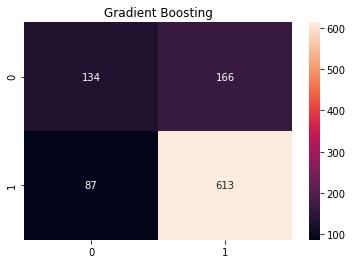

In [51]:
grad_ens_conf_matrix = metrics.confusion_matrix(y, stratified_cv(X, y, ensemble.GradientBoostingClassifier))
sns.heatmap(grad_ens_conf_matrix, annot=True,  fmt='');
title = 'Gradient Boosting'
plt.title(title);

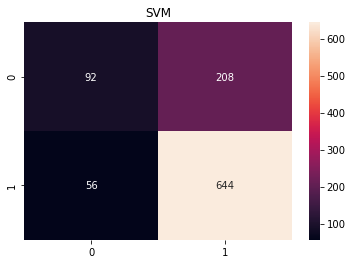

In [52]:
svm_svc_conf_matrix = metrics.confusion_matrix(y, stratified_cv(X, y, svm.SVC))
sns.heatmap(svm_svc_conf_matrix, annot=True,  fmt='');
title = 'SVM'
plt.title(title);

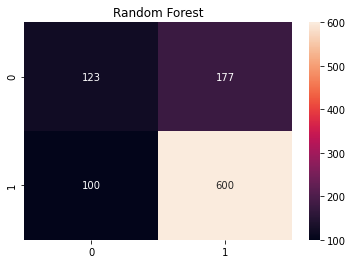

In [53]:
random_forest_conf_matrix = metrics.confusion_matrix(y, stratified_cv(X, y, ensemble.RandomForestClassifier))
sns.heatmap(random_forest_conf_matrix, annot=True,  fmt='');
title = 'Random Forest'
plt.title(title);

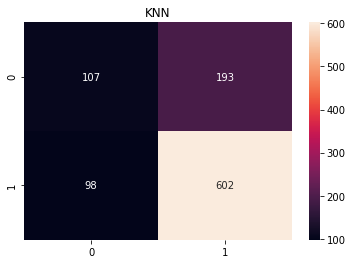

In [54]:
k_neighbors_conf_matrix   = metrics.confusion_matrix(y, stratified_cv(X, y, neighbors.KNeighborsClassifier))
sns.heatmap(k_neighbors_conf_matrix, annot=True,  fmt='');
title = 'KNN'
plt.title(title);

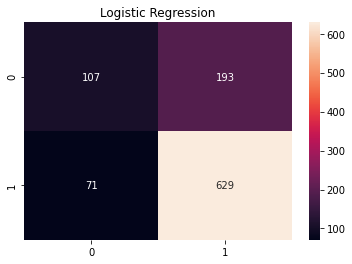

In [55]:
logistic_reg_conf_matrix  = metrics.confusion_matrix(y, stratified_cv(X, y, linear_model.LogisticRegression))
sns.heatmap(logistic_reg_conf_matrix, annot=True,  fmt='');
title = 'Logistic Regression'
plt.title(title);

Reporte de métricas:

In [56]:
print('Gradient Boosting Classifier:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, ensemble.GradientBoostingClassifier))))
print('Support vector machine(SVM):\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, svm.SVC))))
print('Random Forest Classifier:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, ensemble.RandomForestClassifier))))
print('K Nearest Neighbor Classifier:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, neighbors.KNeighborsClassifier))))
print('Logistic Regression:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, linear_model.LogisticRegression))))

Gradient Boosting Classifier:
               precision    recall  f1-score   support

           0       0.61      0.45      0.51       300
           1       0.79      0.88      0.83       700

    accuracy                           0.75      1000
   macro avg       0.70      0.66      0.67      1000
weighted avg       0.73      0.75      0.73      1000


Support vector machine(SVM):
               precision    recall  f1-score   support

           0       0.62      0.31      0.41       300
           1       0.76      0.92      0.83       700

    accuracy                           0.74      1000
   macro avg       0.69      0.61      0.62      1000
weighted avg       0.72      0.74      0.70      1000


Random Forest Classifier:
               precision    recall  f1-score   support

           0       0.56      0.41      0.48       300
           1       0.77      0.86      0.81       700

    accuracy                           0.73      1000
   macro avg       0.67      0.64     

Según el reporte métricas el modelo supervisado de clasificación que mejor desempeño tiene es el GBC o Gradient Boosting Classifier, ya que es el que mejor clasifica los valores recibidos **79% de predicción de los datos de validación**. 

El modelo de Support Vector Machine también se desempeña muy bien y posee el mayor recall de todos, es decir, es el modelo que más items relevantes encuentra.

# <a href="#0"><font size="1">Volver al inicio</font></a>

### <a id="7.2"><font size="4">7.2. Importancia por característica para el clasificador.</font></a>

In [57]:
gbc = ensemble.GradientBoostingClassifier()
gbc.fit(X, y)

GradientBoostingClassifier()

[0.01426174 0.         0.02816308 0.08332805 0.27660576 0.32692451
 0.16990867 0.05677886 0.04402932]


<AxesSubplot:>

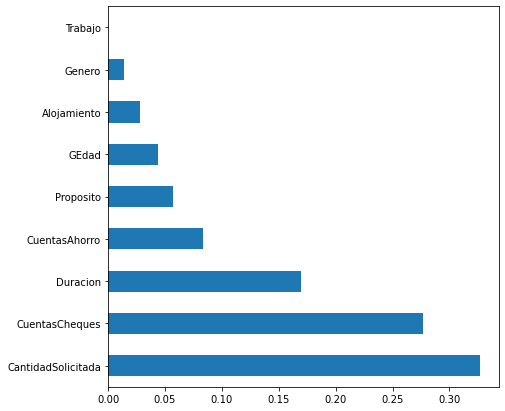

In [58]:
feature_importance = gbc.feature_importances_
print (gbc.feature_importances_)
feat_importances = pd.Series(gbc.feature_importances_, index=df.columns)
feat_importances = feat_importances.nlargest(9)
feat_importances.plot(kind='barh' , figsize=(7,7)) 

**Las características más importantes para la predicción fueron:**

Cantidad Solicitada por el prestatario - 33%

Cuentas de Cheques - 28%

Duración del préstamo - 17%

# <a href="#0"><font size="1">Volver al inicio</font></a>

# <a id="8">8. Simulación del nivel de riesgo</a>


In [100]:
g = int(input('Bienvenido al simulador de riesgo crediticio por favor responda a las siguientes preguntas: \n¿Cuál es su género? 0 para Femenino y 1 para Masculino '))
a = int(input('\n¿Cuál es su tipo de vivienda? 0 para Gratuita, 1 para Propia y 2 para Arrendada '))
ca = int(input(('\nPara las dos siguientes preguntas, poco corresponde a menos de 1 salario minimo (SMMLV), moderado mayor de 1 SMMLV,\n acomodado mayor a 3 y adinerado mayor a 5.\n\n¿El valor de sus cuentas de ahorro es? 0 para Poco, 1 para Moderado, 2 para No posee, 3 para Acomodado y 4 para Adinerado ')))
cc = int(input('\n¿El valor de sus cuentas de cheques es? 0 para Poco, 1 para Moderado, 2 para No posee y 3 para Adinerado '))
cs = int(input('\n¿Cuál es el valor del préstamo que quiere realizar? Escriba un valor en EUR entre 250 a 20.000 '))
d = int(input('\n¿Por cuánto tiempo hará el préstamo? Escriba un valor en meses entre 4 a 72 '))
p = int(input('\n¿Cuál es el propósito de uso para el préstamo? 0 Negocios, 1 Carro, 2 Vacaciones, 3 Educación, 4 Renovación Hogar y 5 TV/radio/entre otros '))
ge = int(input('\n¿En cuál grupo se encuentra referente a su edad? 36-60: Marque 0 18-25: Marque 1, 26-35: Marque 2 o 60++: Marque 3 ')) 

Bienvenido al simulador de riesgo crediticio por favor responda a las siguientes preguntas: 
¿Cuál es su género? 0 para Femenino y 1 para Masculino 1

¿Cuál es su tipo de vivienda? 0 para Gratuita, 1 para Propia y 2 para Arrendada 1

Para las dos siguientes preguntas, poco corresponde a menos de 1 salario minimo (SMMLV), moderado mayor de 1 SMMLV,
 acomodado mayor a 3 y adinerado mayor a 5.

¿El valor de sus cuentas de ahorro es? 0 para Poco, 1 para Moderado, 2 para No posee, 3 para Acomodado y 4 para Adinerado 2

¿El valor de sus cuentas de cheques es? 0 para Poco, 1 para Moderado, 2 para No posee y 3 para Adinerado 3

¿Cuál es el valor del préstamo que quiere realizar? Escriba un valor en EUR entre 250 a 20.000 15000

¿Por cuánto tiempo hará el préstamo? Escriba un valor en meses entre 4 a 72 50

¿Cuál es el propósito de uso para el préstamo? 0 Negocios, 1 Carro, 2 Vacaciones, 3 Educación, 4 Renovación Hogar y 5 TV/radio/entre otros 0

¿En cuál grupo se encuentra referente a su edad?

In [101]:
respuesta = [g,0,a,ca,cc,cs,d,p,ge]
Juan = np.array([1, 0, 1, 2, 2, 16000, 32, 5, 0])
Carolina = np.array([0, 0, 1, 0, 2, 2000, 70, 0, 1])
Tu = np.array(respuesta)

In [102]:
prestatarios_muestra = np.array([Juan,Carolina,Tu])
prestatarios_muestra

array([[    1,     0,     1,     2,     2, 16000,    32,     5,     0],
       [    0,     0,     1,     0,     2,  2000,    70,     0,     1],
       [    1,     0,     1,     2,     3, 15000,    50,     0,     3]])

In [103]:
prestatarios_muestra = scaler.transform(prestatarios_muestra)
print(gbc.predict(prestatarios_muestra))
print(gbc.predict_proba(prestatarios_muestra))

[1 0 1]
[[0.15642535 0.84357465]
 [0.51835033 0.48164967]
 [0.42559059 0.57440941]]


Para el grupo de prestatarios analizado el modelo predice que Carolina tiene un 52% de probabilidad de ser una mala  prestataria o de alto riesgo. Mientras que Juan tiene un 84% de probabilidad de ser de bajo riesgo.

# <a href="#0"><font size="1">Volver al inicio</font></a>

# <a id="9">9. Conclusiones</a>

El programa permite evaluar distintas características y mediante ellas caracterizar un cliente en bueno/bajo riesgo o malo/alto riesgo, lo que ayudaría a mejorar el desempeño de los préstamos en la compañía. Gracias al análisis exploratorio de los datos es claro el porqué las variables de cantidad solicitada y duración tienen tanto impacto en la predicción ya que al analizar los dos grupos se veían diferencias claras.

Los cinco modelos utilizados tuvieron buenas métricas pero resaltaron en su desempeño Gradient Boosting Classifier (GBC) y Support Vector Machine (SVM). Esto se explica en las gráficas ya que era claro la diferencia en las distribuciones, lo que permitia clasificar más fácil según los registros.

Es importante resaltar que entre más cantidad de datos y más características se tengan de los individuos se puede fortalecer aún más el modelo. Estas características se pueden generar mediante una mezcla o relacionamiento de las características actuales.

**Aplicación real**

Se requiere o se debe realizar una base de datos para la organización con información relevante del prestatario (tipo de vivienda, rango salarial, estudios profesionales, empleado o independiente, tipo de contrato, cantidad de préstamo, cuotas, y el output seria como si pago en los plazos o no) y de esta forma se puede crear una variable de calificación entre 1 y 10 (representada por la probabilidad multiplicada por 10).

También, se puede utilizar un algoritmo de clasificación por grupos (clustering u otros modelos no supervisados) y de esta forma la entidad prestamista puede clasificar a los prestatarios.